# Introduction

This is my first attempt on a Kaggle competition! I spent some time analyzing the Titanic probelm and came up with a quick solution with fine accuracy.  The full data exploration and analysis is available at this repository:  https://goo.gl/EYFsdg

# Loading The Data

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.base as skb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost.sklearn import XGBClassifier

data = pd.read_csv('train.csv')

test_data = pd.read_csv('test.csv')

all_data = pd.concat([data, test_data])
all_data.reset_index(drop=True, inplace=True)

all_data.describe(include='all')

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
count,1046.000000,295,1307,1308.000000,1309,1309.000000,1309.000000,1309.000000,1309,1309.000000,891.000000,1309
unique,NaN,186,3,NaN,1307,NaN,NaN,NaN,2,NaN,NaN,929
top,NaN,C23 C25 C27,S,NaN,"Kelly, Mr. James",NaN,NaN,NaN,male,NaN,NaN,CA. 2343
freq,NaN,6,914,NaN,2,NaN,NaN,NaN,843,NaN,NaN,11
mean,29.881138,NaN,NaN,33.295479,NaN,0.385027,655.000000,2.294882,NaN,0.498854,0.383838,NaN
std,14.413493,NaN,NaN,51.758668,NaN,0.865560,378.020061,0.837836,NaN,1.041658,0.486592,NaN
min,0.170000,NaN,NaN,0.000000,NaN,0.000000,1.000000,1.000000,NaN,0.000000,0.000000,NaN
25%,21.000000,NaN,NaN,7.895800,NaN,0.000000,328.000000,2.000000,NaN,0.000000,0.000000,NaN
50%,28.000000,NaN,NaN,14.454200,NaN,0.000000,655.000000,3.000000,NaN,0.000000,0.000000,NaN
75%,39.000000,NaN,NaN,31.275000,NaN,0.000000,982.000000,3.000000,NaN,1.000000,1.000000,NaN


# Feature Engineering & Cleanup

In [38]:
def breakdown_desc(attrib, eff_attrib, orient='v', data=data):
    if orient == 'h':
        x = eff_attrib
        y = attrib
    else:
        x = attrib
        y = eff_attrib
    sns.barplot(x=data[x], y=data[y], order=data.groupby(by=attrib)[eff_attrib].mean().sort_values().index)
    plt.tight_layout()

It is obvious that Name is too complex to use and Cabin has a lot of missing values and the rest are mostly unique. However, we can extract some really useful features from Name and Cabin before throwing them out.

In [39]:
all_data['Title'] = all_data.Name.str.extract('([A-Za-z]+)\\.', expand=False)

all_data.Cabin.fillna('U', inplace=True)
all_data['Deck'] = all_data.Cabin.apply(lambda x: x[0])

all_data['LName'] = all_data.Name.str.extract('([A-Za-z]+),', expand=False)

all_data['FName'] = all_data.Name.str.extract('\\(([A-Za-z]+)', expand=False)
all_data.loc[all_data.FName.isnull(), 'FName'] = all_data.Name[all_data.FName.isnull()] \
.str.extract('\\.\s([A-Za-z]+)', expand=False)

vc = all_data.LName.value_counts()
other = vc[vc < 2]
other[:] = 'Other'
all_data.LName = all_data.LName.replace(other)

vc = all_data.FName.value_counts()
other = vc[vc < 4]
other[:] = 'Other'
all_data.FName = all_data.FName.replace(other)


# all_data.drop(columns=['Name', 'Cabin', 'Ticket'], inplace=True)
all_data.drop('Name', axis=1, inplace=True)
all_data.drop('Cabin', axis=1, inplace=True)
all_data.drop('Ticket', axis=1, inplace=True)

Using the median Age per Title is even more accurate than a regressor, regarding final model accuracy.

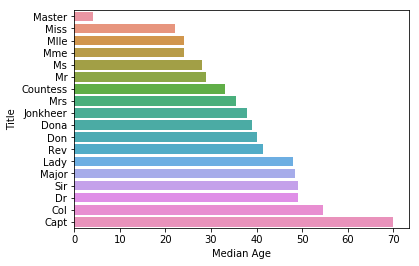

In [40]:
title_med_age = all_data[~all_data.Age.isnull()].groupby(by='Title').Age.median()
sns.barplot(y=title_med_age.index, x=title_med_age.values, 
            order=title_med_age.sort_values().index).set(xlabel='Median Age')
all_data.loc[all_data.Age.isnull(), 'Age'] = title_med_age[all_data[all_data.Age.isnull()].Title].values

Port S has a dominant probability and since only two Embarked entries are missing, it is reasonable to just assume them to be S. 

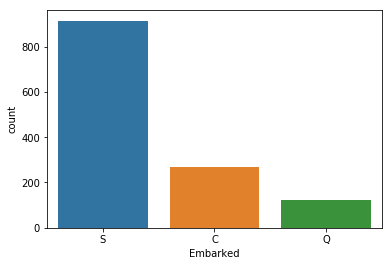

In [41]:
sns.countplot(all_data.Embarked)
all_data.Embarked.fillna('S', inplace=True)

We can use the median fare per class for that missing Fare entry.

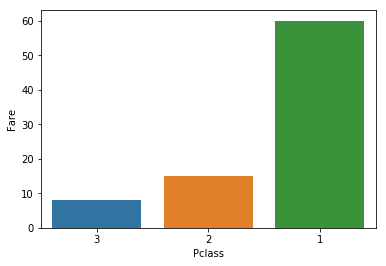

In [42]:
class_med_fare = all_data[~all_data.Fare.isnull()].groupby(by='Pclass').Fare.median()

sns.barplot(x=class_med_fare.index, y=class_med_fare.values,
            order=class_med_fare.sort_values().index).set(ylabel='Fare')

all_data.loc[all_data.Fare.isnull(), 'Fare'] = class_med_fare[all_data[all_data.Fare.isnull()].Pclass].values

In [43]:
all_data.describe(include='all')

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title,Deck,LName,FName
count,1309.000000,1309,1309.000000,1309.000000,1309.000000,1309.000000,1309,1309.000000,891.000000,1309,1309,1309,1309
unique,NaN,3,NaN,NaN,NaN,NaN,2,NaN,NaN,18,9,240,67
top,NaN,S,NaN,NaN,NaN,NaN,male,NaN,NaN,Mr,U,Other,Other
freq,NaN,916,NaN,NaN,NaN,NaN,843,NaN,NaN,757,1014,633,684
mean,29.432521,NaN,33.276193,0.385027,655.000000,2.294882,NaN,0.498854,0.383838,NaN,NaN,NaN,NaN
std,13.163767,NaN,51.743584,0.865560,378.020061,0.837836,NaN,1.041658,0.486592,NaN,NaN,NaN,NaN
min,0.170000,NaN,0.000000,0.000000,1.000000,1.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,22.000000,NaN,7.895800,0.000000,328.000000,2.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
50%,29.000000,NaN,14.454200,0.000000,655.000000,3.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
75%,35.500000,NaN,31.275000,0.000000,982.000000,3.000000,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN


In [44]:
all_data.head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title,Deck,LName,FName
0,22.0,S,7.2500,0,1,3,male,1,0.0,Mr,U,Braund,Other
1,38.0,C,71.2833,0,2,1,female,1,1.0,Mrs,C,Cumings,Florence
2,26.0,S,7.9250,0,3,3,female,0,1.0,Miss,U,Other,Other
3,35.0,S,53.1000,0,4,1,female,1,1.0,Mrs,C,Futrelle,Other
4,35.0,S,8.0500,0,5,3,male,0,0.0,Mr,U,Allen,William


# Correlating and Grouping Features

I saw many people do this type of mapping and, at first, I was skeptical. The idea behind this type of processing is that linearly correlating features with the probability we are trying to predict improves Tree-Based model performance. Since we are using mostly trees in our stack, this greatly helps the overal performance and accuracy.

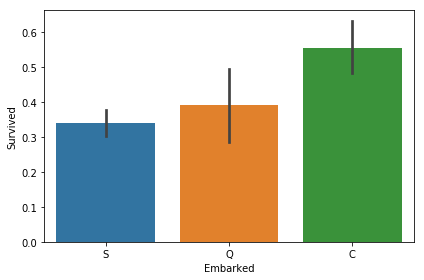

In [45]:
breakdown_desc('Embarked', 'Survived', data=all_data[~all_data.Survived.isnull()])

In [46]:
emb_map = {
    'S':0,
    'Q':1,
    'C':2
}

all_data.Embarked = all_data.Embarked.map(emb_map)

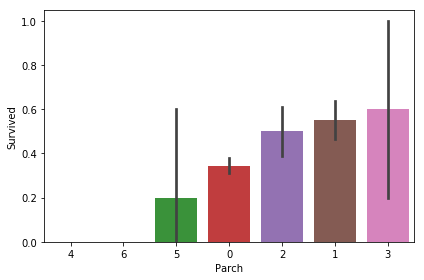

In [47]:
breakdown_desc('Parch', 'Survived', data=all_data[~all_data.Survived.isnull()])

In [48]:
parch_map = {
    9: 0,
    6: 1,
    5: 2,
    4: 3,
    0: 4,
    2: 5,
    1: 6,
    3: 7
}


all_data.Parch = all_data.Parch.map(parch_map)

The Pclass already correlates with survival (inversely).

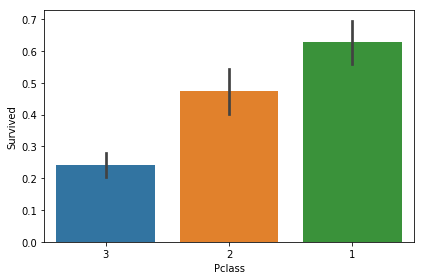

In [49]:
breakdown_desc('Pclass', 'Survived', data=all_data[~all_data.Survived.isnull()])

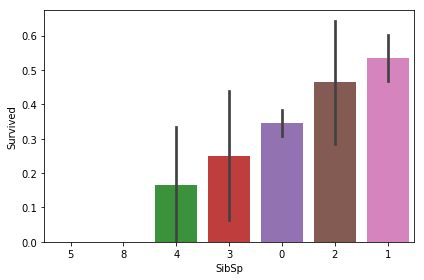

In [50]:
breakdown_desc('SibSp', 'Survived', data=all_data[~all_data.Survived.isnull()])

In [51]:
sibsp_map = {
    8: 0,
    5: 0,
    4: 1,
    3: 2,
    0: 3,
    2: 4,
    1: 5
}

all_data.SibSp = all_data.SibSp.map(sibsp_map)

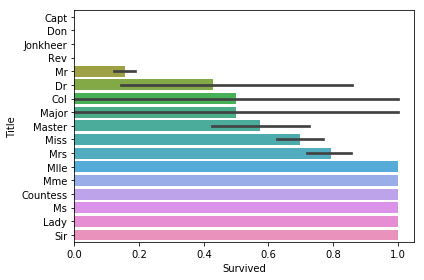

In [52]:
breakdown_desc('Title', 'Survived', data=all_data[~all_data.Survived.isnull()], orient='h')

In [53]:
title_map = {
    # Likely to help others, mostly old
    'Rev': 0,
    'Capt': 0,
    
    # Mostly adult males
    'Mr': 1,
    'Dr': 2,
    
    # Military
    'Col': 3,
    'Major': 3,
    
    # Women and children
    'Master': 4,
    'Miss': 5,
    'Ms': 5,
    'Mlle': 5,
    'Mrs': 6,
    'Mme': 6,
    
    # Lordship titles
    'Jonkheer': 7,
    'Don': 7,
    'Dona': 7,
    'Sir': 7,
    'Lady': 7,
    'Countess': 7
}

all_data.Title = all_data.Title.map(title_map)

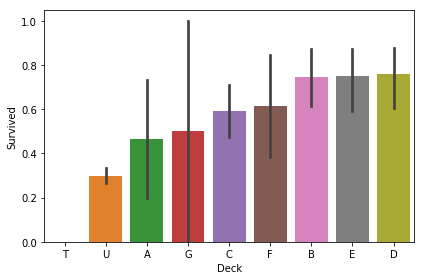

In [54]:
breakdown_desc('Deck', 'Survived', data=all_data[~all_data.Survived.isnull()])

In [55]:
deck_map = {
    'T': 0,
    'U': 1,
    'A': 2,
    'G': 3,
    'C': 4,
    'F': 5,
    'B': 6,
    'E': 7,
    'D': 8
}

all_data.Deck = all_data.Deck.map(deck_map)

Applying the same technique to FName and LName will create false numeric correlation with something abstract like names, which leads to overfitting the data. Interestingly, this does not happen with Title! This is probably because titles are, in a way, hierarchical.

In [56]:
# surv_prob = {}
# vcount = all_data.LName.value_counts()
# for name in all_data.LName.unique():
#     surv_count = np.sum(all_data[all_data.LName == name].Survived)
#     surv_prob[name] = surv_count / vcount[name]

# surv_prob_by_lname = pd.Series(surv_prob).sort_values()

# lname_map = dict(zip(surv_prob_by_lname.index, np.arange(0, len(surv_prob_by_lname))))

# all_data.LName = all_data.LName.map(lname_map)

# surv_prob = {}
# vcount = all_data.FName.value_counts()
# for name in all_data.FName.unique():
#     surv_count = np.sum(all_data[all_data.FName == name].Survived)
#     surv_prob[name] = surv_count / vcount[name]

# surv_prob_by_fname= pd.Series(surv_prob).sort_values()

# fname_map = dict(zip(surv_prob_by_fname.index, np.arange(0, len(surv_prob_by_fname))))

# all_data.FName = all_data.FName.map(fname_map)

Now, we encode the remaining features then scale values to emphasize variance.

In [57]:
all_data.Sex = all_data.Sex.map({'male':0, 'female':1})

all_data.LName = LabelEncoder().fit_transform(all_data.LName)
all_data.FName = LabelEncoder().fit_transform(all_data.FName)

# all_data.Fare = np.log(all_data.Fare+1)

bins = np.arange(all_data.Fare.min()-1, all_data.Fare.max(), 12)
bins[-1] = all_data.Fare.max()+1
all_data.Fare = LabelEncoder().fit_transform(pd.cut(all_data.Fare, bins))

bins = [0, 14, 18, 25, 35, 50, 60, 80]
all_data.Age = LabelEncoder().fit_transform(pd.cut(all_data.Age, bins))

to_scale = ['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Title', 'Deck']
all_data[to_scale] = StandardScaler().fit_transform(all_data[to_scale])

In [58]:
all_data.head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title,Deck,LName,FName
0,-0.548269,-0.622279,-0.613375,-0.436573,1,0.841916,0,1.562046,0.0,-0.810604,-0.489356,29,55
1,0.931491,1.834926,1.102240,-0.436573,2,-1.546098,1,1.562046,1.0,1.520417,1.000334,65,27
2,0.191611,-0.622279,-0.613375,-0.436573,3,0.841916,1,-0.435725,1.0,1.054213,-0.489356,179,55
3,0.191611,-0.622279,0.530368,-0.436573,4,-1.546098,1,1.562046,1.0,1.520417,1.000334,90,55
4,0.191611,-0.622279,-0.613375,-0.436573,5,0.841916,0,-0.435725,0.0,-0.810604,-0.489356,5,66


In [59]:
data_train = all_data[~all_data.Survived.isnull()].drop('PassengerId', axis=1)
data_test = all_data[all_data.Survived.isnull()].drop('Survived', axis=1)

data_train.reset_index(drop=True, inplace=True)
data_test.reset_index(drop=True, inplace=True)

data_train.to_csv('train_proc.csv', index=False)
data_test.to_csv('test_proc.csv', index=False)

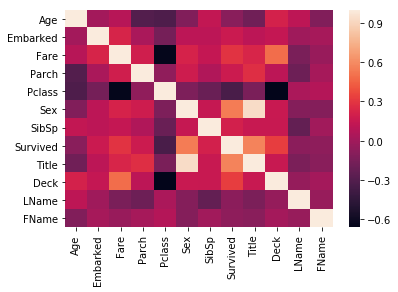

In [60]:
sns.heatmap(data_train.corr())

# Building a Simple Stack of Models

Let's try a simple stack of models without grid searching and using simple wieghted votes.

In [61]:
import warnings
warnings.filterwarnings("ignore")  # XGB/numpy Warning

X = data_train.drop('Survived', axis=1)
y = data_train.Survived

skf = StratifiedKFold(n_splits=8)

models = [SVC(), LogisticRegression(), XGBClassifier(), RandomForestClassifier(), LinearDiscriminantAnalysis()]

model_stack = []

trained_comm = {}

iterations = 30

acc_tot = 0.

print("Training...")
for i in range(iterations):
    print('Iter:', i)
    for train_index, test_index in skf.split(X, y):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        for base in models:
            model = skb.clone(base)
            model.fit(X_train, y_train)
            acc = accuracy_score(y_test, model.predict(X_test))
            acc_tot += acc
            model_stack.append((model, acc))
print('Done.')            
print("Avg. Acc:", acc_tot / len(model_stack))

Training...
Iter: 0
Iter: 1
Iter: 2
Iter: 3
Iter: 4
Iter: 5
Iter: 6
Iter: 7
Iter: 8
Iter: 9
Iter: 10
Iter: 11
Iter: 12
Iter: 13
Iter: 14
Iter: 15
Iter: 16
Iter: 17
Iter: 18
Iter: 19
Iter: 20
Iter: 21
Iter: 22
Iter: 23
Iter: 24
Iter: 25
Iter: 26
Iter: 27
Iter: 28
Iter: 29
Done.
Avg. Acc: 0.7938531270718788


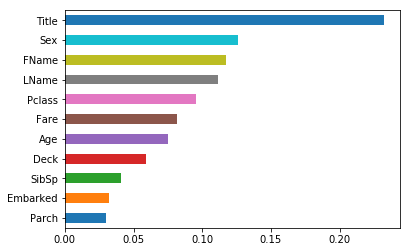

In [62]:
model = model_stack[3][0]
importances = model.feature_importances_
table = pd.Series(importances, index = X_test.columns).sort_values()
table.plot(kind='barh')

In [63]:
pred = np.zeros(data_test.shape[0])

X_test = data_test.drop('PassengerId', axis=1)

for model, w in model_stack:
    pred += model.predict(X_test) * w
pred = np.round(pred/len(model_stack))

df = pd.DataFrame(columns=['PassengerId', 'Survived'])
df.PassengerId = data_test.PassengerId
df.Survived =  pd.to_numeric(pred, downcast='integer')

df.to_csv('output.csv', index=False)

df.Survived.value_counts()

0    270
1    148
Name: Survived, dtype: int64

This model scores 80-82.3% on the leaderboard.